# Binary Classification with Logistic Regression

In [1]:
import mxnet as mx
from mxnet import nd
from mxnet import gluon
from mxnet import autograd

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

## Sigmoid Function

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

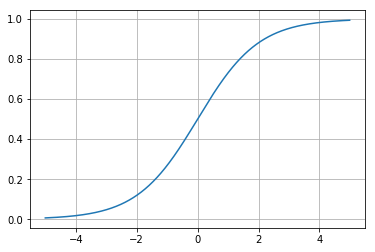

In [2]:
def sigmoid(z):
    return 1 / (1+nd.exp(-z))

x = nd.arange(-5, 5, 0.01)
y = sigmoid(x)
plt.plot(x.asnumpy(), y.asnumpy())
plt.grid(True, which="both")
plt.show()

## binary cross-entropy loss function

交叉熵损失从这个问题开始，一个很自然的问题是给定训练数据，我们想要最大化其所属真实标签的概率：

$$\max_{\theta} P_{\theta}( (y_1, ..., y_n) | \boldsymbol{x}_1,...,\boldsymbol{x}_n )$$

因为每个样本是相互独立的，且每个标签只与其所属的样本的特征有关，因为我们改写如下：

$$\max_{\theta} P_{\theta}(y_1|\boldsymbol{x}_1)P_{\theta}(y_2|\boldsymbol{x}_2) ... P(y_n|\boldsymbol{x}_n)$$

很自然的我们改写为对数形式：

$$\max_{\theta} \log P_{\theta}(y_1|\boldsymbol{x}_1) + ... + \log P(y_n|\boldsymbol{x}_n)$$

考虑到优化问题一般求最小值的问题，所以改写如下：

$$\min_{\theta} \left(- \sum_{i=1}^n \log P_{\theta}(y_i|\boldsymbol{x}_i)\right)$$

我们用$\hat{y_i}$表示第$i$-th个样本属于正类的概率($y_i=1$),很自然的，我们有

$$ P_{\theta}(y_i|\boldsymbol{x}_i) = \begin{cases}
    \hat{y}_i, & \text{if } y_i = 1\\
    1-\hat{y}_i, & \text{if } y_i = 0
\end{cases} $$

上式可以写成

$$ P_{\theta}(y_i|\boldsymbol{x}_i) = \hat{y}_i^{y_i}(1-\hat{y}_i)^{1-y_i} $$

**最终我们可以将我们的损失函数写成**

$$ \ell (\boldsymbol{y}, \boldsymbol{\hat{y}}) =  - \sum_{i=1}^n y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i).$$

## 数据集处理

In [3]:
with open('../data/adult/a1a.train') as f:
    train = f.read()

with open('../data/adult/a1a.test') as f:
    test = f.read()

In [4]:
# 方法一
def process_data(raw_data):
    line_train = raw_data.splitlines()
    num_examples = len(line_train)
    num_features = 123
    X = nd.zeros(shape=(num_examples, num_features))
    y = nd.zeros(shape=(num_examples,1))
    for i, line in enumerate(line_train):
        token = line.split()
        y[0] = (int(token[0]) + 1) / 2 # 把标签值-1变成0，1变成1
        for j, tmp in enumerate(token):
            if j >= 1:
                X[i, int(tmp.split(":")[0])-1] = 1
    return X, y

In [5]:
# 方法二
def process_data(raw_data):
    line_train = raw_data.splitlines()
    num_examples = len(line_train)
    num_feature = 123 
    X = nd.zeros(shape=(num_examples, num_feature))
    y = nd.zeros(shape=(num_examples, 1))
    for i, line in enumerate(line_train):
        tokens = line.split()
        y[i] = label = (int(tokens[0]) + 1) / 2 # 把标签值-1变成0，1变成1
        for token in tokens[1:]: # 注意这里要去除第一个标签
            X[i, int(token[:-2]) - 1] = 1
    return X, y

In [6]:
X_train, y_train = process_data(train)
X_test, y_test = process_data(test)

In [7]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:",y_test.shape)

X_train: (30956, 123)
y_train: (30956, 1)
X_test: (1605, 123)
y_test: (1605, 1)


In [8]:
# 检查均值 以确定我们的训练集和测试集确实是来自同一个分布
print(nd.sum(y_train) / len(y_train))
print(nd.sum(y_test) / len(y_test))


[ 0.24053495]
<NDArray 1 @cpu(0)>

[ 0.24610592]
<NDArray 1 @cpu(0)>


## 使用``gluon``加载数据

In [9]:
batch_size = 64
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X_train, y_train), 
                                   batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X_test, y_test), 
                                  batch_size=batch_size, shuffle=True)

## 定义模型

In [10]:
net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(1))

## 参数初始化

In [11]:
net.collect_params().initialize(mx.init.Normal(sigma=1.))

## 定义优化器

In [12]:
trainer = gluon.Trainer(net.collect_params(), 'Adam')

## 定义交叉熵损失函数

$$ \ell (\boldsymbol{y}, \boldsymbol{\hat{y}}) =  - \sum_{i=1}^n y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i).$$

In [13]:
def log_loss(output, y):
    yhat = sigmoid(output)
    return -nd.sum(y * nd.log(yhat) + (1-y) * nd.log(1 - yhat))

In [14]:
epochs = 30
loss_sequences = []
num_examples = len(X_train)

for epoch in range(epochs):
    cumulative_loss = 0.0
    for i, (data, label) in enumerate(train_data):
        with autograd.record():
            output = net(data)
            loss = log_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    print("Epoch %s, Avg loss %s." % (epoch, cumulative_loss / num_examples))
    loss_sequences.append(cumulative_loss / num_examples)

Epoch 0, Avg loss 0.89525416557.
Epoch 1, Avg loss 0.579159844213.
Epoch 2, Avg loss 0.453228757061.
Epoch 3, Avg loss 0.395693625201.
Epoch 4, Avg loss 0.366177118538.
Epoch 5, Avg loss 0.350102210757.
Epoch 6, Avg loss 0.340846782138.
Epoch 7, Avg loss 0.335374269949.
Epoch 8, Avg loss 0.332131855062.
Epoch 9, Avg loss 0.330033271839.
Epoch 10, Avg loss 0.328465388871.
Epoch 11, Avg loss 0.327464263343.
Epoch 12, Avg loss 0.326741708097.
Epoch 13, Avg loss 0.326082158141.
Epoch 14, Avg loss 0.325682655849.
Epoch 15, Avg loss 0.325375393451.
Epoch 16, Avg loss 0.325053291398.
Epoch 17, Avg loss 0.324841489101.
Epoch 18, Avg loss 0.324588004525.
Epoch 19, Avg loss 0.324462798634.
Epoch 20, Avg loss 0.3243022567.
Epoch 21, Avg loss 0.324150376548.
Epoch 22, Avg loss 0.324003499906.
Epoch 23, Avg loss 0.323984317315.
Epoch 24, Avg loss 0.323923445623.
Epoch 25, Avg loss 0.323712996725.
Epoch 26, Avg loss 0.323691891706.
Epoch 27, Avg loss 0.323626944162.
Epoch 28, Avg loss 0.323578722826

## 绘制损失函数曲线

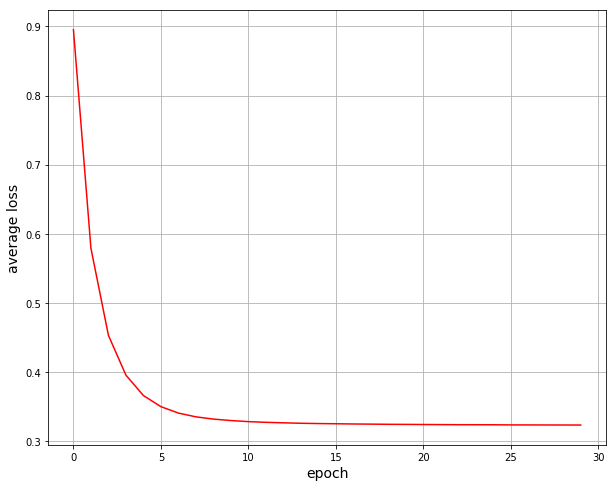

In [15]:
plt.figure(num=None, figsize=(10,8))
plt.plot(list(range(len(loss_sequences))),loss_sequences, 'r')
plt.xlabel("epoch", fontsize="14")
plt.ylabel("average loss", fontsize="14")
plt.grid(True, which="both")
plt.show()

## 计算准确率 (accuracy)

In [16]:
num_correct = 0.0
num_test_examples = len(X_test)

for i, (data, label) in enumerate(test_data):
    output = net(data)
    prediction = (nd.sign(output) + 1) / 2 # 把标签值-1变成0，1变成1
    num_correct += nd.sum(prediction == label)
print("Accuracy %.3f, (%s / %s)" % (num_correct.asscalar() / num_test_examples, num_correct.asscalar(), 
                                    num_test_examples))

Accuracy 0.842, (1352.0 / 1605)
